In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path

In [2]:
# Defining number of input parameters and number of outputs in the feature 
num_samples = 150
num_harmonics = 20
num_input_parameter = 35

##### Exploring signac workspace
1. Extracts Surface Evolver parameters and corresponding EFD related shape features for the parameter screening

In [3]:
# Fetching project from signac workspace
project = signac.get_project()

LookupError: Unable to determine project id for path 'C:\Users\Nilay\Documents\GitHub\Tissue-Cartography\parameter_screening'.

In [4]:
""" This section of the code does the following tasks
1. Creating input and output training data for building surrogate models
2. The input data is stored in master_parameter_input array with shape [num_samples,num_parameters]
3. The output data is stored in master_parameter_output array with shape [num samples, 4 x num_harmonics]
4. The section additionally plots wing imaginal disc shape through reverse EFD  as a result of changes made in the parameter
"""

# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )
else:
    # Initializing input and output data
    master_parameter_input = np.zeros([1, 35])
    master_feature_output = np.zeros([1,80])

    # Itearting throgh each job in workspace
    for job in project:

        isFile = os.path.isfile(job.fn("signac_job_document.json"))
        if isFile == True:
            # Fetching input parameters from the .json file containing setpoints
            input_param = job.statepoint()["parameter_model"]
            # Coverting array to a numpy array
            input_param = np.array(input_param)
            # Reshaping the array to concatenate to the master input 
            input_param_reshaped = np.reshape(input_param, (1, len(input_param)))
            # Vertical concatenation of the job specific input parameter list to the mster input data
            master_parameter_input = np.vstack((master_parameter_input,input_param_reshaped))

            # Fetching efd coefficients from the output data in signac
            efd_coeff = job.document.get("e_f_d")
            # Converting to numpy array
            efd_coeff = np.array(efd_coeff)
            # Converting efd coeff to xy data for visualization
            xt, yt = spatial_efd.inverse_transform(efd_coeff, harmonic=20)
            plt.plot(xt,yt,label=str(input_param[33]))
            plt.axes().set_aspect('equal', 'datalim')
            # Reshaping efd coeff in a shape of a row 
            efd_coeff = np.reshape(efd_coeff, (1,80))
            # Stacking output features for creating a master output feature matrix
            master_feature_output = np.vstack((master_feature_output,efd_coeff))


    plt.legend(loc='upper left',ncol = 2, prop={'size': 6})      
    plt.show()

    # Deleting the first row containing zeros
    master_feature_output = np.delete(master_feature_output, 0, 0)
    master_parameter_input = np.delete(master_parameter_input, 0, 0)

    # Renaming files for saving
    master_feature_output = master_feature_output
    master_parameter_input_n = master_parameter_input
    
    # saving files 
    np.save('master_parameter_input_n.npy', master_parameter_input_n)
    np.save('master_feature_output.npy', master_feature_output)



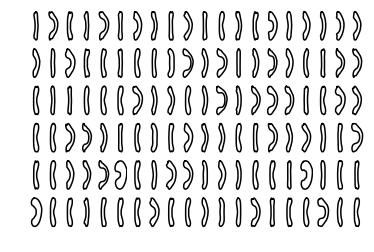

In [5]:
"""Visualizing shapes
"""
plt.close()
for i in range(120):
    temp = master_feature_output[i,:]
    temp2 = np.reshape(temp, (20,4))
    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)
    plt.subplot(6,20,i+1)
    plt.plot(xt,yt,color="black")
    plt.xticks(xt, " ")
    plt.xticks(yt, " ")
    plt.axis("off")
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.axes().set_aspect('equal', 'datalim')
    
plt.show()
    
    

In [6]:
"""This section of code is useful when we have to merge a new data from workspace to existing datafile
"""
#master_parameter_input_1 = np.load('master_parameter_input_1.npy', )
#master_feature_output_1 = np.load('master_feature_output_1.npy', )
#master_parameter_input_2 = np.load('master_parameter_input_2.npy', )
#master_feature_output_2 = np.load('master_feature_output_2.npy', )
#master_parameter_input_3 = np.load('master_parameter_input_3.npy', )
#master_feature_output_3 = np.load('master_feature_output_3.npy', )

# Combining data from multiple parameter screens
#master_parameter_input_n = np.vstack((master_parameter_input_1,master_parameter_input_2,master_parameter_input_3))
#master_feature_output = np.vstack((master_feature_output_1,master_feature_output_2,master_feature_output_3))
#np.save('master_parameter_input_n.npy', master_parameter_input_n)
#np.save('master_feature_output.npy', master_feature_output)

print(np.shape(master_parameter_input_n))
print(np.shape(master_feature_output))




(150, 35)
(150, 80)


##### Visualizing correlations: Input parameters to EFD features

In [7]:
"""This section is meant to describe the correlations between the input parameter space and the output EFD features describing shape
   a) dataframes were created for the input and output data
   b) seaborn.pairplot was used to visualize correlations between EFD coefficients and input parameters
   c) Definition of parameters varied in LHS
       i) param_2 - T_squamous_basal 
       ii) param_5 - T_cuboidal_basal
       iii) param_8 - T_columnar_basal
       iv) param_18 - k_columnar_basal
       v) param_19 - k_columnar_apical
       vi) param_20 - k_columnar_lateral
       vii) param_34 - k_ecm
"""
from sklearn.preprocessing import StandardScaler

# Transforming input parameter data to log scale
master_parameter_input = np.log(master_parameter_input_n)

# Defining labels for the EFD coefficients
efd_labels = ["EFD_0"]
for i in range(1,4*num_harmonics):
    label_to_append = "EFD_"+str(i)
    efd_labels.append(label_to_append)
# Creating dataframe for the output shape feature matrix
df_output_features = pd.DataFrame(master_feature_output, columns = efd_labels)


# Defining labels for the parameters
parameter_labels = ["param_1"]
for i in range(1,35):
    label_to_append = "param_"+str(i+1)
    parameter_labels.append(label_to_append)
# Creatiing dataframe for the inpur parameters    
df_input_parameters = pd.DataFrame(master_parameter_input, columns = parameter_labels)

# merging in the input and output dataframes  
df_input_output_merged = pd.concat([df_output_features, df_input_parameters], axis=1)

"""
# Importing seaborn library
import seaborn as sns
# Creating a pairplot for visualizing correlation
snsplot = sns.pairplot(
              df_input_output_merged,
              x_vars = ["param_2","param_5","param_8","param_18","param_19","param_20","param_34"],
              y_vars = efd_labels
          )
# Saving plot to a file
snsplot.savefig("correlation_param_efd.png")
"""

C:\Users\Nilay\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


'\n# Importing seaborn library\nimport seaborn as sns\n# Creating a pairplot for visualizing correlation\nsnsplot = sns.pairplot(\n              df_input_output_merged,\n              x_vars = ["param_2","param_5","param_8","param_18","param_19","param_20","param_34"],\n              y_vars = efd_labels\n          )\n# Saving plot to a file\nsnsplot.savefig("correlation_param_efd.png")\n'

In [8]:
""" A) his section of code proejects the feature space into lower dimensions using PCA
b) Scikit learn was first used to normalize the data and then take principal components
c) Varaince captured in the principal components is also estimated
d) Further the section plots the correlations between KECM and different principal components
"""
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Storing the feature output data in x
x = master_feature_output
# Normalizing the data
x = StandardScaler().fit_transform(x)
# Defining number of components in PCA
pca = PCA(n_components=8)
# Using scikit learn to calculate PCs
principalComponents = pca.fit_transform(x)
# Calculating weights
weights = pca.components_
print(np.shape(weights))
# Variance explained in the principal components
print(pca.explained_variance_ratio_)




(8, 80)
[0.21895301 0.17323367 0.11290526 0.09812456 0.08294328 0.05576723
 0.04099771 0.03003538]


**Surrogate modeling**

A)Input: Parameters varoied in LHS

B) PCs of the EFD shape features
Build individual models relating the Input parameters to the individual PCs of EFD features

In [9]:
""" Importing librarie
"""

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
""" TRSAINING AND TESTING DATA FOR GPR MODEL
    a) This section of the code prepares the training data for the GPR model.
    b) Parameter that were varied during the LHS rae chosen as the input variables to the model.
    c) Output training data are the PCs of the PCs of the EFD features
    d) A split is carried out in the inut and output data to create a training and testing dataset for model
    
"""

# Number of parameters in the Latin Hypercube sampling
num_parameters_LHS = 7
param_index = [1, 4, 7, 17, 18, 19, 33]
# Initializing the training data
train_x_numpy = np.zeros((num_samples, num_parameters_LHS))
# Getting the parameter values from master_parameter_input
for i in range(num_parameters_LHS):
    train_x_numpy[:,i] = master_parameter_input[:,param_index[i]]

# Normalizing the data around mean
train_x_numpy = StandardScaler().fit_transform(train_x_numpy)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Defining a RBF kernel
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #defing a Matern kernel
        # mu is the smoothness parameter
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()






In [14]:

num_pts = 100
gpr_prediction_mean = np.zeros((num_pts, 1))
gpr_prediction_var = np.zeros((num_pts, 1))
actual_output = np.zeros((num_pts, 1))
iter_counter = np.zeros((num_pts, 1))
pc_index_train = 7
for i in range(num_pts):
    train_x_del = np.delete(train_x_numpy, i, 0)
    #print(np.shape(train_x_del))
    train_y_del = np.delete(principalComponents, i, 0)
    #print(np.shape(train_y_del))
    train_x = torch.from_numpy(train_x_del)
    train_y1 = torch.from_numpy(train_y_del[:,pc_index_train])
    #print(train_x)
    test_x = torch.from_numpy(train_x_numpy)
    #print(test_x)
    actual_output[i] = principalComponents[i,pc_index_train]
    model1 = ExactGPModel(train_x, train_y1, likelihood)
    
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 1000
    model1.train()
    likelihood.train()
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.1)
    mll1 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model1)
    
    for j in range(training_iter):
        optimizer1.zero_grad()
        output = model1(train_x)
        loss = -mll1(output, train_y1)
        loss.backward()
        optimizer1.step()
        
    model1.eval()
    likelihood.eval()
    f_preds = model1(test_x)
    f_mean = f_preds.mean.detach().numpy()
    gpr_prediction_mean[i] = f_mean[i]
    #print(np.shape(f_mean))
    f_var = f_preds.variance.detach().numpy()
    gpr_prediction_var = f_var[i]
    #rint(np.shape(f_var))
    iter_counter[i] = i+1
    
    print("Currently in iteration" + str(i))
        

Currently in iteration0
Currently in iteration1
Currently in iteration2
Currently in iteration3
Currently in iteration4
Currently in iteration5
Currently in iteration6
Currently in iteration7
Currently in iteration8
Currently in iteration9
Currently in iteration10
Currently in iteration11
Currently in iteration12
Currently in iteration13
Currently in iteration14
Currently in iteration15
Currently in iteration16
Currently in iteration17
Currently in iteration18
Currently in iteration19
Currently in iteration20
Currently in iteration21
Currently in iteration22
Currently in iteration23
Currently in iteration24
Currently in iteration25
Currently in iteration26
Currently in iteration27
Currently in iteration28
Currently in iteration29
Currently in iteration30
Currently in iteration31
Currently in iteration32
Currently in iteration33
Currently in iteration34
Currently in iteration35
Currently in iteration36
Currently in iteration37
Currently in iteration38
Currently in iteration39
Currently 

In [15]:
print(gpr_prediction_mean)

[[ 1.46563204e-01]
 [-2.86233010e-01]
 [ 5.38263025e-01]
 [-1.64550705e-01]
 [ 2.74746318e-02]
 [ 1.66526889e-01]
 [-3.28851167e-01]
 [ 1.67523733e-01]
 [ 4.18475669e-01]
 [ 1.02246441e-02]
 [-7.35699904e-02]
 [-2.53003626e-01]
 [ 6.20995221e-01]
 [ 4.54705899e-01]
 [ 7.95485249e-02]
 [-5.32571234e-02]
 [ 1.16088660e-01]
 [-1.33192651e-01]
 [ 1.25094234e-01]
 [ 1.14276057e-01]
 [-1.54814970e-02]
 [-4.94197489e-01]
 [-2.18224085e-02]
 [ 2.19253854e-01]
 [ 1.29896289e-01]
 [-7.98259645e-01]
 [ 1.94333397e-01]
 [-5.64389221e-01]
 [ 1.97204455e-01]
 [ 1.82403971e-01]
 [-6.99304273e-02]
 [-5.38794015e-02]
 [ 3.30545332e-01]
 [ 2.25468458e-01]
 [ 4.24008240e-02]
 [-2.30925859e-01]
 [-4.90836006e-01]
 [ 1.57794830e-01]
 [ 1.95161458e-01]
 [ 2.28809474e-01]
 [ 9.08746978e-01]
 [-2.55101151e-01]
 [-2.83929920e-02]
 [-1.79516578e-01]
 [-1.50480357e-01]
 [ 2.92772610e-01]
 [ 5.25392513e-01]
 [-8.14124010e-04]
 [-1.75515400e-02]
 [-1.72352517e-01]
 [-1.32960482e-01]
 [-3.21568171e-02]
 [-1.1161985

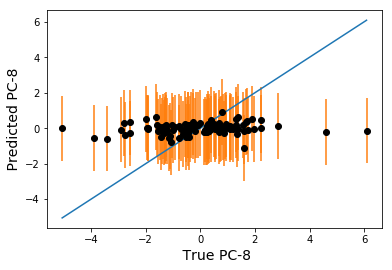

In [17]:

# Discretizing coordinate system for updating the parietal_plots
x_par = np.linspace(np.amin(actual_output),np.amax(actual_output), num = 100)
# Plotting the parietal line y = x
fig, ax = plt.subplots(1)
ax.plot(x_par, x_par)
# Plotting the output predictions against known output value
ax.plot(actual_output, gpr_prediction_mean, 'o', color='black')
# Plotting the errorbars
ax.errorbar(actual_output, gpr_prediction_mean,
             yerr = gpr_prediction_var, linestyle = "None")
# Labelling the axes
#ax.fill_between(original_output, upper1_numpy, lower1_numpy, facecolor='blue', alpha=0.5)

ax.set_xlabel(" True PC-8", fontsize = 14)
ax.set_ylabel(" Predicted PC-8 ", fontsize = 14)

plt.show()